# Covid-19 Prediction Project

### Objective:
We are seeking to use the global data on the COVID-19 pandemic in order to predict the number of cases as a fuction of time in each country and for the world. We will be using data science tools and python to come up with our predictions and analysis.
### Purpose:
We believe that this could type of prediction could be useful for a variety of different parties. Economists, policy makers, producers of essential goods, and even local business owners could stand to benefit from more accurate information regarding the pandemic.

We also believe that the team will be able to develop our data science, python, and communication skills through this project. 

## Project outline
1. Import packages and data
2. Visualize and process the data
3. Build, score, and compare different predictive models
4. Analyze results
5. Conclusions and recommendations

## Import neccessary packages

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import warnings
warnings.simplefilter("ignore")
import datetime
from sklearn.metrics import mean_absolute_error

## Import and process data

In [0]:
df=pd.read_csv("covid_confirmed.csv")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,678,712,726,736,750,766,773,782,789,795
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,731,738,738,743,743,743,745,745,747,748
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,26,27,27,27,27,30,35,35


In [0]:
cols=df.keys()
confirmed=df.loc[:, cols[4]:cols[-1]]
dates=confirmed.keys()
countries=set(list(df["Country/Region"]))
days_since=list((range(len(dates))))

In [0]:
world_confirmed=[]
china_confirmed=[]
italy_confirmed=[]
usa_confirmed=[]
world_rate=[]
china_rate=[]
italy_rate=[]
usa_rate=[]
for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_confirmed.append(confirmed_sum)
    china_confirmed.append(df[df['Country/Region']=='China'][i].sum())
    italy_confirmed.append(df[df['Country/Region']=='Italy'][i].sum())
    usa_confirmed.append(df[df['Country/Region']=='US'][i].sum())
for i in days_since:
    if i == 0:
        world_rate.append(0)
        china_rate.append(0)
        italy_rate.append(0)
        usa_rate.append(0)
    else:
        world_rate.append((world_confirmed[i]-world_confirmed[i-1])*100/world_confirmed[i-1])
        china_rate.append((china_confirmed[i]-china_confirmed[i-1])*100/china_confirmed[i-1])
        italy_rate.append((italy_confirmed[i]-italy_confirmed[i-1])*100/italy_confirmed[i-1])
        usa_rate.append((usa_confirmed[i]-usa_confirmed[i-1])*100/usa_confirmed[i-1])
        
        
    

## Visualize data

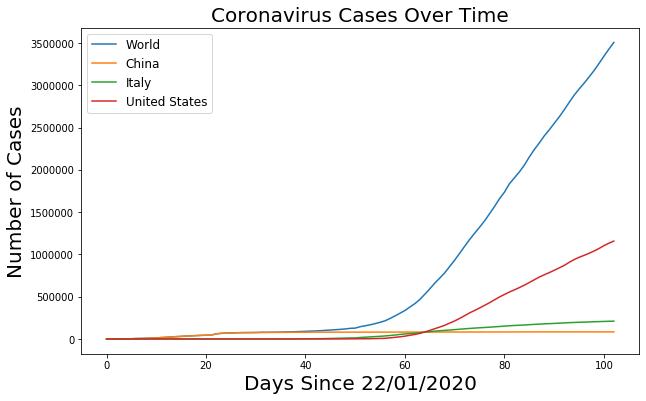

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(days_since, world_confirmed)
plt.plot(days_since, china_confirmed)
plt.plot(days_since, italy_confirmed)
plt.plot(days_since, usa_confirmed)
plt.legend(['World', 'China', 'Italy', 'United States'], prop={'size': 12})
plt.title('Coronavirus Cases Over Time', size=20)
plt.xlabel('Days Since 22/01/2020', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

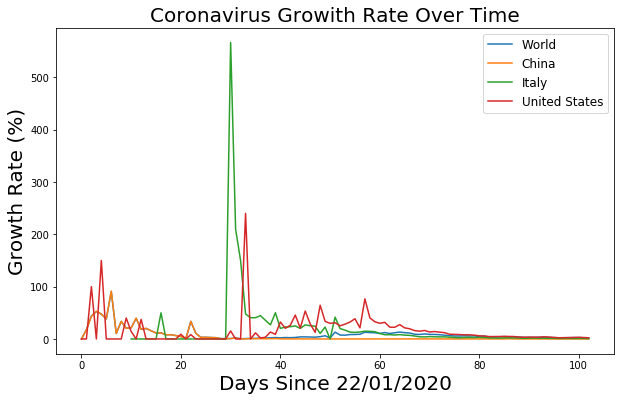

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(days_since, world_rate)
plt.plot(days_since, china_rate)
plt.plot(days_since, italy_rate)
plt.plot(days_since, usa_rate)
plt.legend(['World', 'China', 'Italy', 'United States'], prop={'size': 12})
plt.title('Coronavirus Growith Rate Over Time', size=20)
plt.xlabel('Days Since 22/01/2020', size=20)
plt.ylabel('Growth Rate (%)', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

## Build model and split data

In [0]:
dfC19=pd.read_csv("covid_19_data.csv")
dfC19.drop(["SNo"],1,inplace=True)
dfC19["ObservationDate"]=pd.to_datetime(dfC19["ObservationDate"])
dfC19['Country']=dfC19['Country/Region']
dfC19.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Country
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,Mainland China
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,Mainland China
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,Mainland China
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,Mainland China
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,Mainland China


In [0]:
from datetime import timedelta
daily_cases=dfC19.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
daily_cases["DaysAfter1-22"]=daily_cases.index-daily_cases.index.min()
daily_cases['PandemicDeclared']=0   
for i in range(len(daily_cases["DaysAfter1-22"])):
    if daily_cases["DaysAfter1-22"][i] > timedelta(days=49):
        daily_cases['PandemicDeclared'][i]=1  
daily_cases["DaysAfter1-22"]=daily_cases["DaysAfter1-22"].dt.days
daily_cases

,Confirmed,Recovered,Deaths,DaysAfter1-22,PandemicDeclared
ObservationDate,,,,,
2020-01-22,555.0,28.0,17.0,0,0
2020-01-23,653.0,30.0,18.0,1,0
2020-01-24,941.0,36.0,26.0,2,0
2020-01-25,1438.0,39.0,42.0,3,0
2020-01-26,2118.0,52.0,56.0,4,0
...,...,...,...,...,...
2020-04-27,3041764.0,893967.0,211167.0,96,1
2020-04-28,3116398.0,928658.0,217153.0,97,1
2020-04-29,3193886.0,972719.0,227638.0,98,1


In [0]:
from sklearn.model_selection import train_test_split
tests=np.arange(0.10,0.35,0.01).tolist()
model_test_world=[]
model_degree_world=[]
model_mse_world=[]
y_world=daily_cases.loc[:,['Confirmed']]
X_world=daily_cases.loc[:,['DaysAfter1-22','PandemicDeclared']]
for i in range(10):
    for j in tests:
        X_train_world, X_test_world, y_train_world, y_test_world = train_test_split(X_world, y_world, test_size=j, random_state=42)
        model_world=SVR(C=1,degree=i,kernel='poly',epsilon=0.01,gamma='scale')
        model_world.fit(X_train_world,y_train_world)
        prediction_valid_svm_world=model_world.predict(X_test_world)
        model_degree_world.append(i)
        model_test_world.append(j)
        model_mse_world.append(np.sqrt(mean_squared_error(y_test_world,prediction_valid_svm_world)))
k_world=model_mse_world.index(min(model_mse_world))
print("Degree of Fit:",model_degree_world[k_world],"\t Amount of Data Trained:",str((1-model_test_world[k_world])*100)+"%")
print(model_mse_world[k_world])

Degree of Fit: 9 	 Amount of Data Trained: 87.0%
342162.3455527014


## Score SVM model and visualize predictions
write a blurb here about why this model was used

### Worldwide Cases

MSE: 342162.3455527014


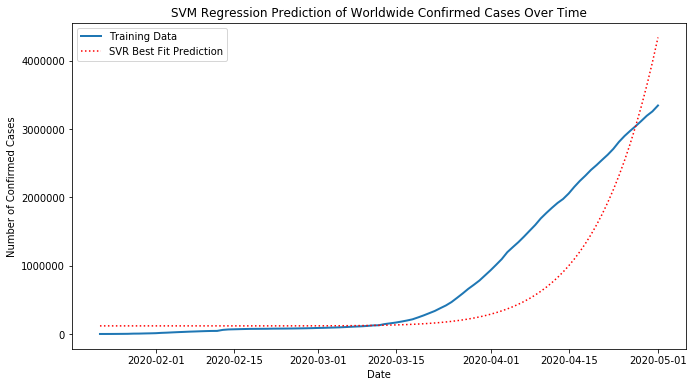

In [0]:
X_train_world, X_test_world, y_train_world, y_test_world = train_test_split(X_world, y_world, test_size=model_test_world[k_world], random_state=42)
model_world=SVR(C=1,degree=model_degree_world[k_world],kernel='poly',epsilon=0.01,gamma='scale')
model_world.fit(X_train_world,y_train_world)
prediction_valid_svm_world=model_world.predict(X_test_world)
print("MSE:",np.sqrt(mean_squared_error(y_test_world,prediction_valid_svm_world)))
prediction_svm_world=model_world.predict(X_world)
plt.figure(figsize=(11,6))
plt.plot(daily_cases["Confirmed"],label="Training Data",linewidth=2)
plt.plot(daily_cases.index,prediction_svm_world, linestyle=':',label="SVR Best Fit Prediction",color='red')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.title("SVM Regression Prediction of Worldwide Confirmed Cases Over Time")
plt.legend()

### US Cases

In [0]:
usa_filter=dfC19.Country.isin(["US"])
df_usa=dfC19[usa_filter]
daily_cases_usa=df_usa.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
daily_cases_usa["DaysAfter1-22"]=daily_cases_usa.index-daily_cases_usa.index.min()
daily_cases_usa["DaysAfter1-22"]=daily_cases_usa["DaysAfter1-22"].dt.days

In [0]:
tests=np.arange(0.10,0.35,0.01).tolist()
model_test_usa=[]
model_degree_usa=[]
model_mse_usa=[]
y_usa=daily_cases_usa.loc[:,['Confirmed']]
X_usa=daily_cases_usa.loc[:,['DaysAfter1-22']]
for i in range(10):
    for j in tests:
        X_train_usa, X_test_usa, y_train_usa, y_test_usa = train_test_split(X_usa, y_usa, test_size=j, random_state=1)
        model_usa=SVR(C=1,degree=i,kernel='poly',epsilon=0.01,gamma='scale')
        model_usa.fit(X_train_usa,y_train_usa)
        prediction_valid_svm_usa=model_usa.predict(X_test_usa)
        model_degree_usa.append(i)
        model_test_usa.append(j)
        model_mse_usa.append(np.sqrt(mean_squared_error(y_test_usa,prediction_valid_svm_usa)))
k_usa=model_mse_usa.index(min(model_mse_usa))
print("Degree of Fit:",model_degree_usa[k_usa],"\t Amount of Data Trained:",str((1-model_test_usa[k_usa])*100)+"%")
print(model_mse_usa[k_usa])

Degree of Fit: 5 	 Amount of Data Trained: 70.0%
74792.53905932269


MSE: 74792.53905932269


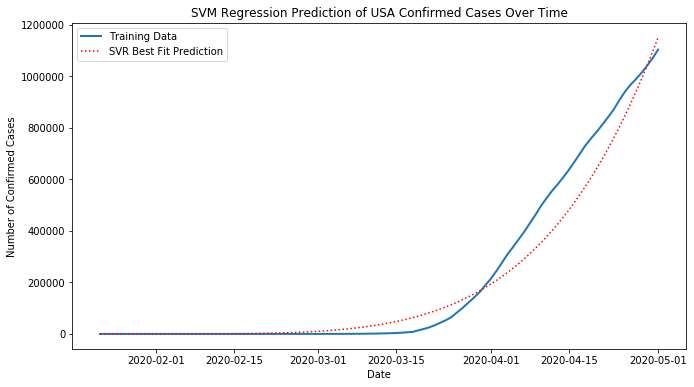

In [0]:
X_train_usa, X_test_usa, y_train_usa, y_test_usa = train_test_split(X_usa, y_usa, test_size=model_test_usa[k_usa], random_state=1)
model_usa=SVR(C=1,degree=model_degree_usa[k_usa],kernel='poly',epsilon=0.01,gamma='scale')
model_usa.fit(X_train_usa,y_train_usa)
prediction_valid_svm_usa=model_usa.predict(X_test_usa)
print("MSE:",np.sqrt(mean_squared_error(y_test_usa,prediction_valid_svm_usa)))
prediction_svm_usa=model_usa.predict(X_usa)
plt.figure(figsize=(11,6))
plt.plot(daily_cases_usa["Confirmed"],label="Training Data",linewidth=2)
plt.plot(daily_cases_usa.index,prediction_svm_usa, linestyle=':',label="SVR Best Fit Prediction",color='red')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.title("SVM Regression Prediction of USA Confirmed Cases Over Time")
plt.legend()

### China Cases 

In [0]:
china_filter=dfC19.Country.isin(["Mainland China"])
df_china=dfC19[china_filter]
daily_cases_china=df_china.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
daily_cases_china["DaysAfter1-22"]=daily_cases_china.index-daily_cases_china.index.min()
daily_cases_china["DaysAfter1-22"]=daily_cases_china["DaysAfter1-22"].dt.days

In [0]:
tests=np.arange(0.10,0.35,0.01).tolist()
model_test_china=[]
model_degree_china=[]
model_mse_china=[]
y_china=daily_cases_china.loc[:,['Confirmed']]
X_china=daily_cases_china.loc[:,['DaysAfter1-22']]
for i in range(10):
    for j in tests:
        X_train_china, X_test_china, y_train_china, y_test_china = train_test_split(X_china, y_china, test_size=j, random_state=1)
        model_china=SVR(C=1,degree=i,kernel='poly',epsilon=0.01,gamma='scale')
        model_china.fit(X_train_china,y_train_china)
        prediction_valid_svm_china=model_china.predict(X_test_china)
        model_degree_china.append(i)
        model_test_china.append(j)
        model_mse_china.append(np.sqrt(mean_squared_error(y_test_china,prediction_valid_svm_china)))
k_china=model_mse_china.index(min(model_mse_china))
print("Degree of Fit:",model_degree_china[k_china],"\t Amount of Data Trained:",str((1-model_test_china[k_china])*100)+"%")
print(model_mse_china[k_china])

Degree of Fit: 3 	 Amount of Data Trained: 74.00000000000001%
7962.8387424052735


MSE: 7962.8387424052735


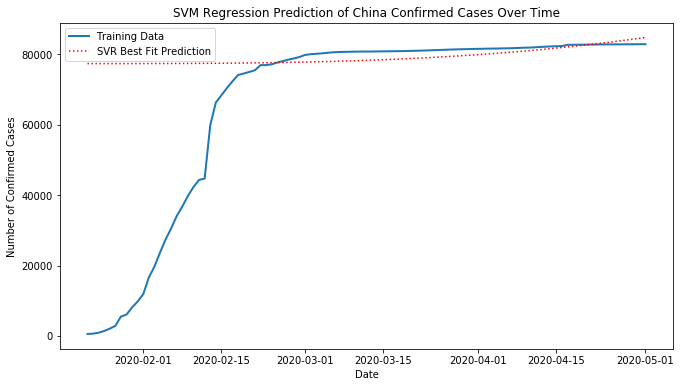

In [0]:
X_train_china, X_test_china, y_train_china, y_test_china = train_test_split(X_china, y_china, test_size=model_test_china[k_china], random_state=1)
model_china=SVR(C=1,degree=model_degree_china[k_china],kernel='poly',epsilon=0.01,gamma='scale')
model_china.fit(X_train_china,y_train_china)
prediction_valid_svm_china=model_china.predict(X_test_china)
print("MSE:",np.sqrt(mean_squared_error(y_test_china,prediction_valid_svm_china)))
prediction_svm_china=model_china.predict(X_china)
plt.figure(figsize=(11,6))
plt.plot(daily_cases_china["Confirmed"],label="Training Data",linewidth=2)
plt.plot(daily_cases_china.index,prediction_svm_china, linestyle=':',label="SVR Best Fit Prediction",color='red')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.title("SVM Regression Prediction of China Confirmed Cases Over Time")
plt.legend()

## Score Logistic model and visualize predictions

In [0]:
dfCovLog = df.drop(columns=['Province/State','Long', 'Lat']).groupby('Country/Region').sum().transpose()
dfCovLog.loc[:,'World'] = dfCovLog.sum(axis=1)
dfCovLog.loc[:,'Date'] = pd.to_datetime(dfCovLog.index)
dfCovLog = dfCovLog.reset_index(drop=True)
dfCovLog.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe,World,Date
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,555,2020-01-22
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,654,2020-01-23
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,941,2020-01-24
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1434,2020-01-25
4,0,0,0,0,0,0,0,0,4,0,...,0,0,2,0,0,0,0,0,2118,2020-01-26


In [0]:
#Defining Logistic Growth Function
def logisticf(t,a,b,c):
    logistic_growth=c/(1+a*np.exp(-b*t))
    return logistic_growth

# Run Model & Gather Predictions

In [0]:
def split_data_log(data, country, test_size=0.25):
    train = data.loc[data.index < len(data)*(1-test_size), country]
    test = data.loc[data.index >= len(data)*(1-test_size), country]
    return train.index, test.index, train, test

In [0]:
country_list = ['US','Italy','World','China']
x = dfCovLog.index

import scipy.optimize as optim
from sklearn.metrics import mean_absolute_error

results = dict()

# Loop over countries...
for country in country_list:
    try:
        y = dfCovLog[country]
        # Split and process data for each country
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)
        #x_train, x_test, y_train, y_test = split_data_log(dfCovLog, country, test_size=0.20)
        # Set up parameters for building model
        p0=np.random.exponential(size=3)
        bounds =(0,[10000., 3000., 100000000.])
        (a,b,c), cov = optim.curve_fit(logisticf, x_train,y_train, bounds=bounds,p0=p0)        
        # Feed parameters to fit equation
        def logigrowth(t):
            return  c/(1+a*np.exp(-b*t))
        # Predict
        y_test_pred = logigrowth(x_test)
        # Evaluate based on mae
        mae = mean_absolute_error(y_test, y_test_pred)
        
        #print(country, 'mae:',round(mae), 'total cases:', y_test.iloc[-1], round(mae/y_test.iloc[-1]*100),'%')
        x_plot = range(len(x) + 20)
        y_test_pred_plot = logigrowth(x_plot)
        plot_stuff = x_plot, y_test_pred_plot
        # Save mae, total cases into dict
        results[country] = (mae, dfCovLog[country].iloc[-1], plot_stuff)
    except RuntimeError as e:
        print(f"{country} - {e}")
    except ValueError as e:
        print(f"{country} - {e}")  

# Predict Data (Scoring)

In [0]:
for country in results.keys():
    print(f"{country}: mae = {round(results[country][0])}, total cases = {results[country][1]}")
    print(f"{country}: error = {round(results[country][0]/results[country][1]*100)} %")

US: mae = 15472.0, total cases = 1158040
US: error = 1.0 %
Italy: mae = 3310.0, total cases = 210717
Italy: error = 2.0 %
World: mae = 61688.0, total cases = 3506729
World: error = 2.0 %
China: mae = 1794.0, total cases = 83964
China: error = 2.0 %


In [0]:
def view_results_log(country):
    x_test, y_test_pred = results[country][2]
    plt.plot(x_test,y_test_pred ,label='predictions')
    plt.plot(dfCovLog.reset_index().index, dfCovLog[country], label='acutal')
    plt.legend()
    plt.title(country)
    plt.xlabel('Days since 01-22-2020')
    plt.ylabel('Confirmed Cases')

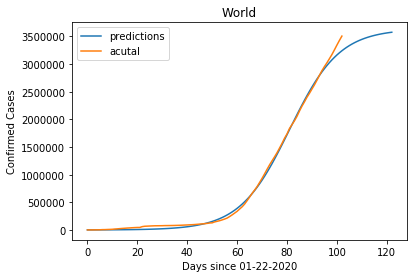

In [0]:
view_results_log('World')

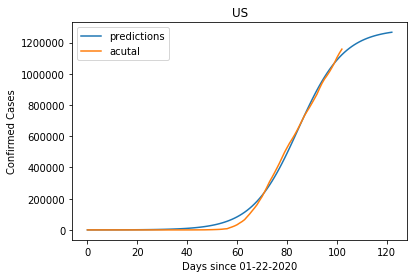

In [0]:
view_results_log('US')

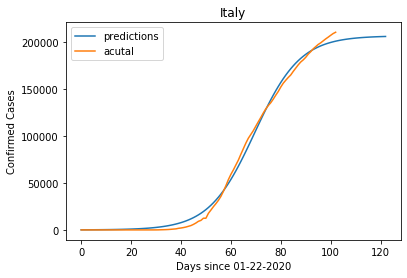

In [0]:
view_results_log('Italy')

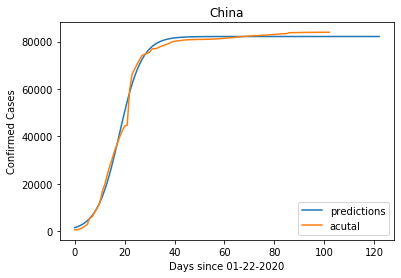

In [0]:
view_results_log('China')